### Implementation of the Paper ["A Single Backlit Image Enhancement Method For Improvement Of Visibility Of Dark Part"](https://ieeexplore.ieee.org/document/9506526) by M. Akai _et al._


### Imports


In [1]:
import numpy as np
from PIL import Image
from scipy.signal import convolve2d

import matplotlib.pyplot as plt

In [2]:
PREFIX = "./Images"

#### Hyperparameters

- **GAMMA:** 2
- **ALPHA:** 0.7
- **EPSILON:** 1e-7


In [3]:
parameters = {
    "FIGURE": "fig1.png",
    "GAMMA": 2,
    "ALPHA": 0.7,
    "EPSILON": 1e-7
}

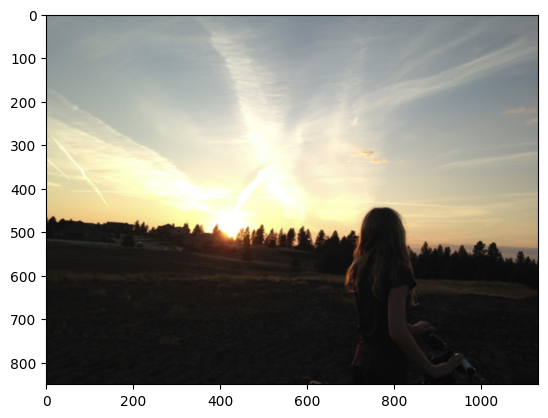

In [4]:
img = Image.open(f"{PREFIX}/{parameters['FIGURE']}")

img = np.asarray(img)
img = img[:, :, :3]

plt.imshow(img)
plt.show()

#### Grayscale Image (by taking mean of all channels)


In [5]:
img_grayscale = np.mean(img.astype(np.float32), axis=2)

img_grayscale.shape

(850, 1132)

In [6]:
def plot_intensity_histogram(image, title=None):
    if len(image.shape) != 2:
        print("[ERROR]: Image must be grayscale image with only 2 dimensions.")
        return

    figure, (hist_ax, image_ax) = plt.subplots(1, 2, figsize=[15, 4])

    image = image.astype(np.uint8)
    image_flattened = image.flatten()
    _ = hist_ax.hist(image_flattened, bins="auto")

    hist_ax.set_xlabel("Intensity")
    hist_ax.set_ylabel("Frequency")
    hist_ax.set_title(f"{title} - Intensity Histogram")

    image_ax.set_title(f"{title} - Image")
    image_ax.imshow(image, cmap="gray")

    plt.show()

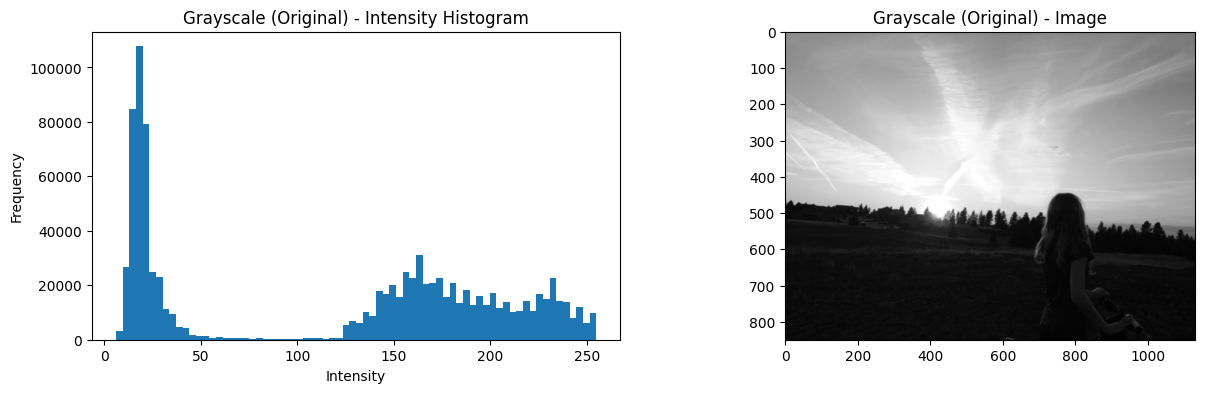

In [7]:
plot_intensity_histogram(img_grayscale, "Grayscale (Original)")

#### Gamma Correction


In [8]:
gamma = parameters["GAMMA"]
img_gamma = 255.0 * (img_grayscale / 255.0) ** (1.0 / gamma)

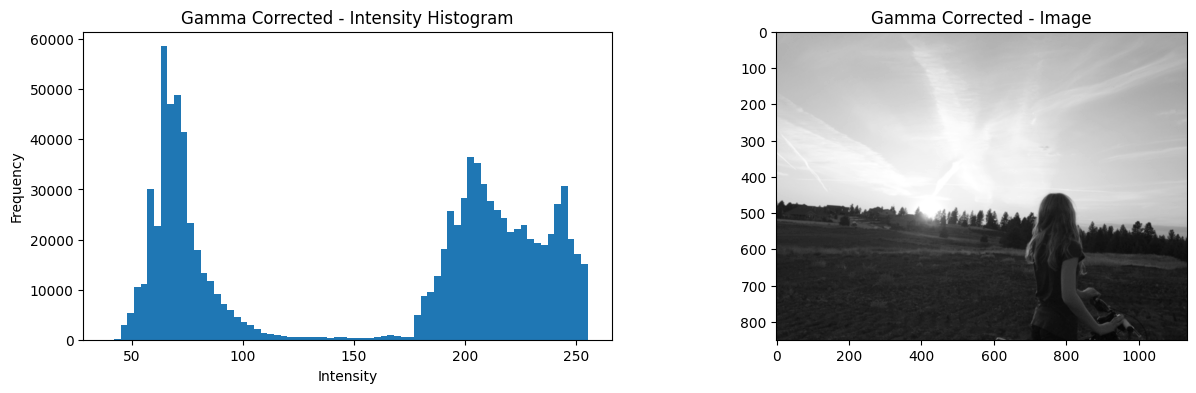

In [9]:
plot_intensity_histogram(img_gamma, "Gamma Corrected")

#### Histogram Equalization


In [10]:
def image_histogram_equalization(image):
    # get image histogram
    image_histogram, bins = np.histogram(image.astype(np.uint8).flatten(), 256, density=True)
    cdf = image_histogram.cumsum()
    cdf = 255 * cdf / cdf[-1]

    # linear interpolation
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [11]:
img_he = image_histogram_equalization(img_grayscale)

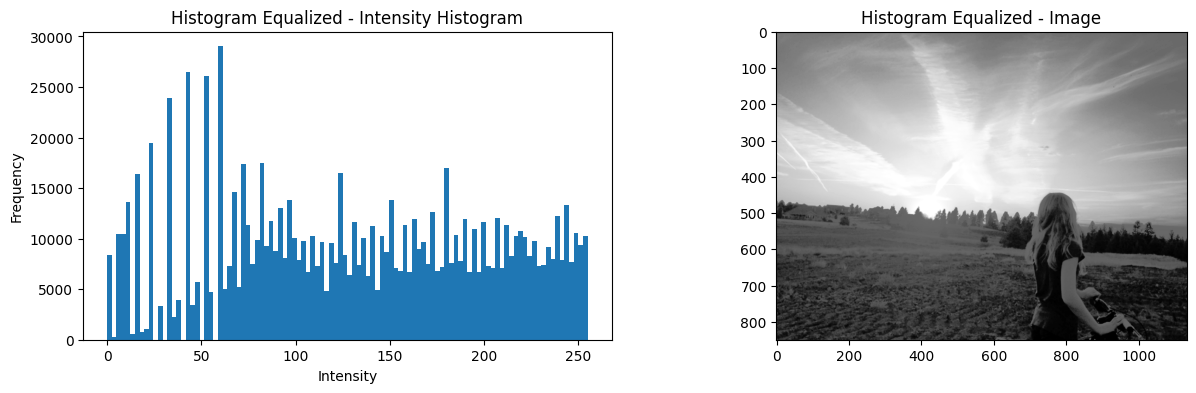

In [12]:
plot_intensity_histogram(img_he, "Histogram Equalized")

#### Alpha Bending of the Gamma Corrected and Histogram equalized images.


In [13]:
alpha = parameters["ALPHA"]
img_alpha_bent = (1.0 - alpha) * img_gamma + alpha * img_he

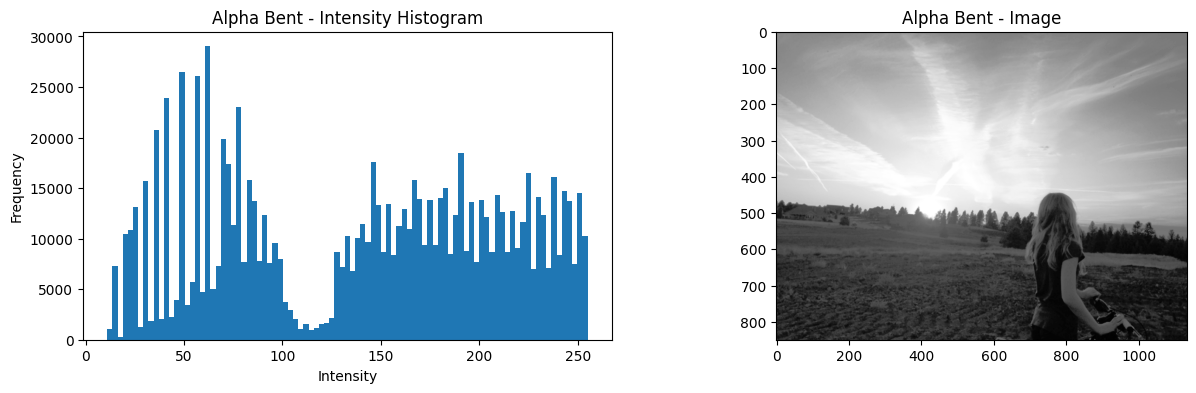

In [14]:
plot_intensity_histogram(img_alpha_bent, "Alpha Bent")

#### Obtaining the ideal threshold value which maximizes the optimization function:

$$ω_bω_w(m_b - m_w)^2$$

_here:_

- $ω_b$: Number of pixels belonging to **black** class.
- $ω_w$: Number of pixels belonging to **white** class.
- $m_b$: Mean of pixels belonging to **black** class.
- $m_w$: Mean of pixels belonging to **white** class.

##### Obtaining binary weight map:

$$
\begin{equation*}
    W_{ij} =
    \begin{cases}
        1 & I_{ij} < t, \\
        0 & otherwise
    \end{cases}
\end{equation*}
$$


In [15]:
def get_threshold_and_binary_weight_map(image):
    def objective_fnc(image_flat, threshold):
        condition = image_flat < threshold
        a = image_flat[condition]
        b = image_flat[~condition]
        if a.shape[0] == 0 or b.shape[0] == 0:
            return 0.0
        return a.shape[0] * b.shape[0] * (np.mean(a) - np.mean(b)) ** 2

    image_flat = image.flatten()
    objective_values = [objective_fnc(image_flat, t) for t in range(256)]

    best_t = np.argmax(objective_values)

    return best_t, np.where(image < best_t, 1.0, 0.0)

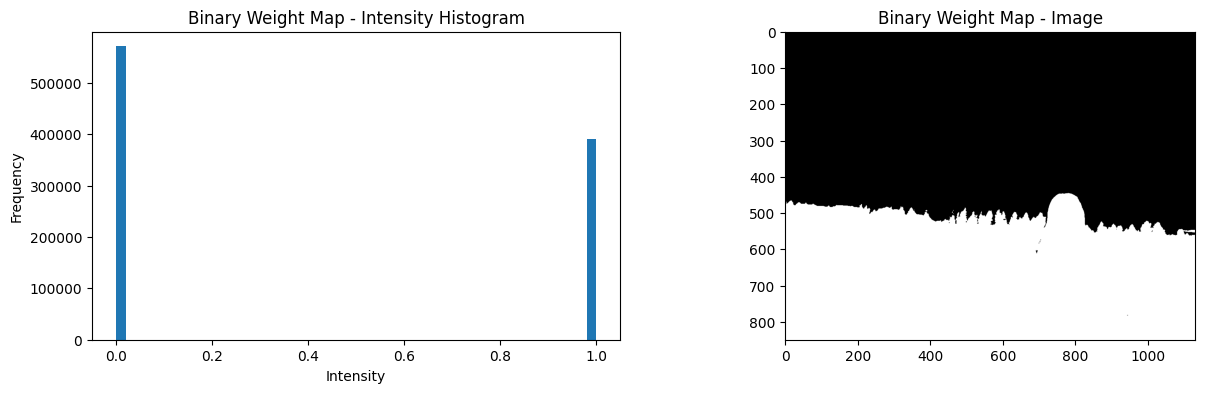

In [16]:
threshold, W = get_threshold_and_binary_weight_map(img_grayscale)

plot_intensity_histogram(W, "Binary Weight Map")

#### Obtaining the weight map using the grayscale image and binary weight map:

$$
\begin{split}
    \tilde{W} &= \overline{a} \otimes \overline{{I^{nor}}} + \overline{b} \\
    a = (\overline{I^{nor} \otimes W} &- \overline{I^{nor}} \otimes \overline{W}) \oslash(\overline{I^{nor} \otimes I^{nor}} - \overline{I^{nor}}^2 + ϵ) \\
    b &= \overline{W} - a \otimes \overline{I^{nor}}
\end{split}
$$


In [17]:
# Method to give box-filter of 2d Matrix using scpy Convolve2d.
# For Box-Filter, the kernel consists of 1 / (kernel_size ^ 2),
# which is the mean of all elements of the kernel.
def box_filter(MAT, filter_size: int = 1):
    kernel_size = 2 * filter_size + 1
    kernel = np.ones((kernel_size, kernel_size), np.float32) / kernel_size**2

    filtered_MAT = convolve2d(MAT, kernel, mode="same", boundary="symm")

    return filtered_MAT


def get_A(image_nor_tuple, binary_weight_map_tuple, filter_size: int = 1):
    image_nor, image_filtered_nor = image_nor_tuple
    binary_weight_map, binary_filtered_weight_map = binary_weight_map_tuple

    filtered_i_mul_w = box_filter(image_nor * binary_weight_map, filter_size)  # M bar
    filtered_i_nor_sq = box_filter(image_nor * image_nor, filter_size)  # J bar
    image_nor_filtered_sq = image_filtered_nor * image_filtered_nor

    numerator = filtered_i_mul_w - image_filtered_nor * binary_filtered_weight_map
    denominator = (filtered_i_nor_sq - image_nor_filtered_sq) + parameters["EPSILON"]

    return numerator / denominator


def get_weight_map(image, binary_weight_map, filter_size: int = 1):
    image_filtered = box_filter(image, filter_size)  # Probably not required.

    image_nor = image / 255.0
    image_filtered_nor = box_filter(image_nor, filter_size)  # I bar

    binary_filtered_weight_map = box_filter(binary_weight_map, filter_size)  # W bar

    A = get_A(
        (image_nor, image_filtered_nor),
        (binary_weight_map, binary_filtered_weight_map),
        filter_size,
    )

    # Using Image_Filtered_NOR instead of Image_Filtered
    # Probable BUG in paper's mathematics.
    B = binary_filtered_weight_map - A * image_filtered_nor

    filtered_A = box_filter(A, filter_size)
    filtered_B = box_filter(B, filter_size)

    return filtered_A * image_nor + filtered_B

In [18]:
weight_map = get_weight_map(img_grayscale, W, 1)

# weight_map = (weight_map) / (np.max(weight_map))

weight_map.shape

(850, 1132)

#### Final Intesity and RGB image:

$$
\begin{split}
    \tilde{O}_{ij} = \tilde{W}_{ij} \cdot O_{ij} + (1 - \tilde{W}_{ij}) \cdot I_{ij} \ \ \ ∀\ \  i,j \\
    \tilde{O}_{ij}^{RGB} = I_{ij}^{RGB} \cdot (\tilde{O}_{ij} / I_{ij}) \ \ \ ∀\ \  i,j
\end{split}
$$


In [19]:
final_intensity = weight_map * img_alpha_bent + (1.0 - weight_map) * img_grayscale
final_intensity /= img_grayscale + parameters["EPSILON"]

final_image = img * np.expand_dims(final_intensity, axis=2)

final_image.shape

(850, 1132, 3)

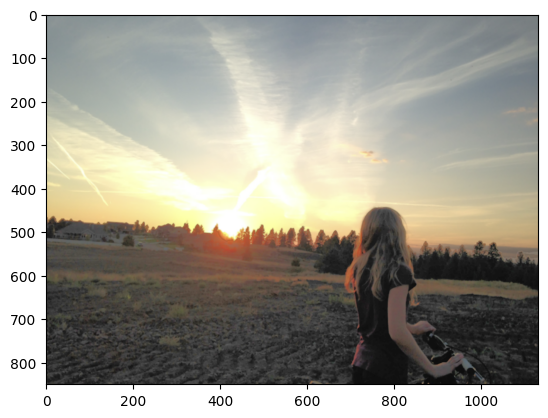

In [20]:
plt.imshow(final_image.astype(np.uint8))
plt.show()

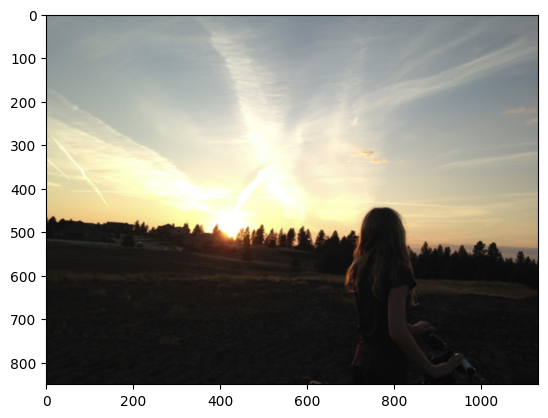

In [21]:
plt.imshow(img.astype(np.uint8))
plt.show()